# Классификация комментариев пользователей

## Постановка задачи

### Описание 

На основе исходных данных с разметкой о токсичности правок разработать модель, которая бы классифицировала комментарии пользователей о товарах интернет-магазина на позитивные и негативные. Модель должна соответствовать значению метрики качества F1 не меньше 0.75. 

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
#!pip install torch-lr-finder
#!pip install transformers
!pip install hyperopt

In [112]:
import re
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')

from joblib import Parallel, delayed
from tqdm import tqdm, notebook

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import transformers
import torch

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin
from functools import partial

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
data = pd.read_csv('toxic_comments.csv')

In [5]:
data.sample(7)

,text,toxic
82442,"What a hypocrite this creep Chavez is!\n\nFrom the main article about Hugo Chavez:\n\nChávez was raised a Roman Catholic, although he has had a series of disputes with both the Venezuelan Catholic hierarchy and Protestant groups like the New Tribes Mission. He has traditionally kept his own faith a private matter, but over the course of his presidency, Chávez has become increasingly open to discussing his religious views, stating that both his faith and his interpretation of Jesus' personal life and ideology have had a profound impact on his left-wing and progressivist views. He often invokes God and asks for prayer in speeches, as he did when he asked Venezuelans to pray for Fidel Castro's health.\n\nI find it ironic that an atheist such as Hugo Chavez would ask the Venezuelan people to pray to God for another atheist's (Fidel Castro) health! This just shows what a hypocrite and liar Chavez is!",1
132112,"""\nAh I needed to stay away for a day and clear my mind. I wasn't gone for long. ) | talk """,0
30078,The true words of a moron,1
130901,", 7 September 2010 (UTC)\n\nThat Op-ed is 90% about criticism of the US system and I'm not sure that is relevant to this article. Did you see where he says there's a pretty good argument that she should have been found innocent? Fair enough. Wikipedia articles are supposed to report facts about opinions. Is his opinion notable? That's a close call. I'm calling for quite a bit of discussion about what observers say about the trial. He's saying he doesn't like the US response, not that he agrees with the verdict. The lengthy criticism section I put together wasn't necessarily intended to go in as is. The idea is that it puts in one place content that I believe belongs in various places in the article. Feel free to say what you think is wrong with what I wrote in that criticism section. 13:25",0
90549,I didn't ask how often you jerk off. A Simpsons episode is where the mass of twitchy muscle is from. 69.158.165.129,1
130019,"""\n File:CarlsburgBeer.JPG listed for deletion \nA file that you uploaded or altered, File:CarlsburgBeer.JPG, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why it has been listed (you may have to search for the title of the image to find its entry). Feel free to add your opinion on the matter below the nomination. Thank you. hi! """,0
77359,"""\n\nPS: “Blackpearl14"""" Do you, your friends and family or any contributors, editors, administrators or Mr. Wales or their friends and family own stock within the Walt Disney Company? The Walt Disney Company page is not neutral, it is a series of promotional pages including links to products and causes of the Walt Disney Company. Many of the other statements on the Walt Disney Company page don’t follow your so-called neutral definition. Following your own claim of “neutral”, the entire page would have to be deleted per your own standards. Furthermore, the lawsuit sentence that was placed on it, was exactly as the other statements of “criticism” within the Walt Disney Company page, yet you claim it’s not neutral. Clearly you enforce double standards and don’t adhere to wikipedia’s own written polices. \nCriticism\nDisney has on several occasions prompted action from religious groups such as the Catholic League, due to purported insensitive broadcasting, and the release of films, which the league and others found offensive. Disney has faced boycotts from Baptist groups, """"Assemblies of God"""", and Catholic groups in the past. (boycott 1;boycott 2;boycott 3) \nThe worldwide commercial success of the Disney brand is viewed by some as detrimental to cultural diversity (see Disneyfication).\nDisney is one among several American companies lobbying for more stringent enforcement of intellectual property around the world and continued copyright term extensions, posing a perceived threat to the existence of the public domain; see Copyright Term Extension Act.\nDisney has been accus

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
data['toxic'].value_counts()

0    143346
1    16225 
Name: toxic, dtype: int64

Обратим внимание на дисбаланс классов в исходной выборке: значений "1" в столбце целевого признака составяет чуть больше 10% от общего количества записей. Это необходимо будет учесть при построении моделей.

#### Прописные буквы

Есть предположение, что токсичные комментарии связаны с повышенным эмоциональным состоянием человека, которые он выражает через набор текста прописными буквами для усиления эффекта воздействия. Думается, что человек в спокойном состоянии для нейтрального комментария будет придерживаться правил правписания. Проверим.

In [8]:
data.loc[data['toxic'] == 1]['text'].sample(5)

27548     FUCK YOU \n\nFUCK YOU ASSHOLE                                                                                                                                                                                                                                                                                                                                                                                                                     
42557     Jesus Christ, I can't edit anything without stupid pimple faced kids editing my work.                                                                                                                                                                                                                                                                                                                                                             
141377    "\n Well, when the root problem is a miserable, lowlife scumbag like you? BUNG-HO(LE)?! Eh, I basica

Стоит отметить, что нас интересуют не просто прописные буквы в тексте, а идующие подряд, а также их соотношение по отношению к общему слов в тексте. 

In [9]:
data['length'] = data['text'].apply(lambda x: len(x))

Интересно также посмотреть, как отличаются по размеру текстов токсичные и нейтральные комментарии.

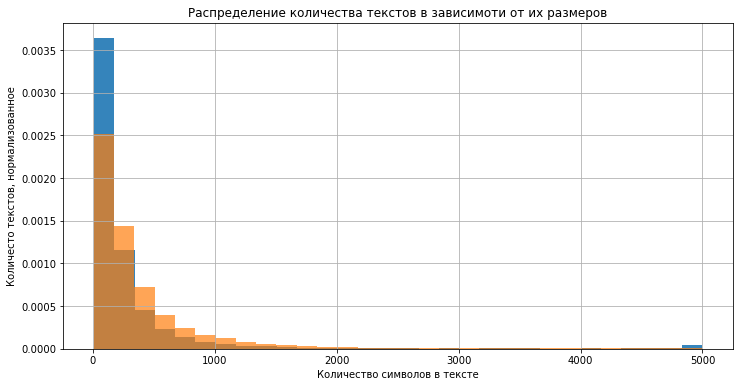

In [10]:
data.query('toxic == 1')['length'].plot(kind = 'hist', bins = 30, figsize = (12, 6), alpha = 0.9, density = True)
data.query('toxic == 0')['length'].plot(kind = 'hist', bins = 30, grid = True,  alpha = 0.7, density = True)

plt.title('Распределение количества текстов в зависимоти от их размеров')
plt.xlabel('Количество символов в тексте')
plt.ylabel('Количесто текстов, нормализованное')
plt.show()

По графикам видим, что токсичные и нейтральные тексты особо не отличаются друг от друга. Интересно было посмотреть на распределение количества текстов в зависимости от отношения числа слов, набранных прописными буквами, к общему количеству слов в тексте. Однако, иногда комментарии могут состоять из текстов без пробелов или, наоборот, с большим количеством пробелов, поэтому будет считать не по отношению к общему количеству слов, а по отошению к общему количеству символов в тексте.

In [11]:
data['caps'] = data['text'].apply(lambda x: len(re.findall(r'[A-Z]{2,}', x))) / data['text'].apply(lambda x: len(x))

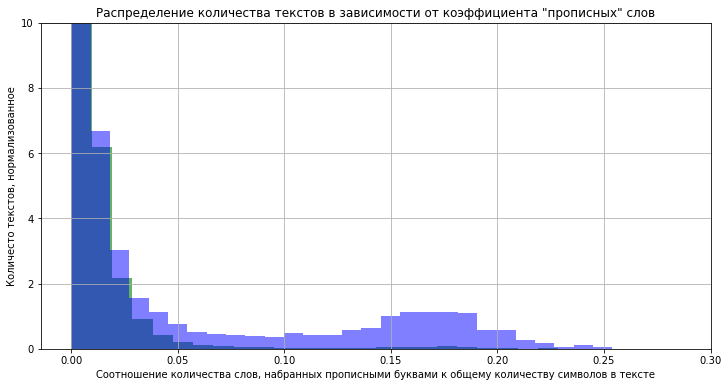

In [12]:
plt.figure(figsize = (12, 6))
data.query('toxic == 0 & caps < 1')['caps'].plot(x = 'caps', kind = 'hist', 
                                                 bins = 30, alpha = 0.6, 
                                                 color = 'green',  density = True)

data.query('toxic == 1 & caps < 1')['caps'].plot(x = 'caps', kind = 'hist', 
                                                 bins = 30, alpha = 0.5, 
                                                 color = 'blue', density = True)

plt.title('Распределение количества текстов в зависимости от коэффициента "прописных" слов')
plt.xlabel('Соотношение количества слов, набранных прописными буквами к общему количеству символов в тексте')
plt.ylabel('Количесто текстов, нормализованное')

plt.ylim(0, 10)
plt.grid()
plt.show()

По графику видно, что ориентировочно до значения коэффициента "прописных" слов =0,05 токсичные тексты не отличаются от нейтральных текстов, но далее, с ростом коэффициента (количества "прописных" слов) нейтральных текстов становится гораздо меньше токсичных. Причем со значения =0,125 наблюдается существенный рост токсичных текстов. Таким образом, наше предположение подтвердилось, оставим данный коэффициент в качестве нового признака.

#### Восклицательные знаки

Второе предположение является продолжением первого: для усиления своего токсичного комментария пользователь употребляет большое количество восклицательных знаков. Проверим наше предположение.

In [13]:
data['ex_point'] = data['text'].apply(lambda x: 
                                      len(re.findall(r'[!]', x))) / data['text'].apply(lambda x: len(x))

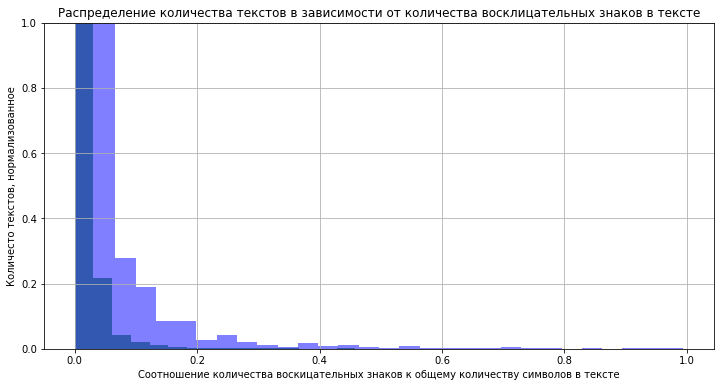

In [14]:
plt.figure(figsize = (12, 6))
data.query('toxic == 0')['ex_point'].plot(kind = 'hist', 
                                                 bins = 30, alpha = 0.6, 
                                                 color = 'green',  density = True)

data.query('toxic == 1')['ex_point'].plot(kind = 'hist', 
                                                 bins = 30, alpha = 0.5, 
                                                 color = 'blue', density = True)

plt.title('Распределение количества текстов в зависимости от количества восклицательных знаков в тексте')
plt.xlabel('Соотношение количества воскицательных знаков к общему количеству символов в тексте')
plt.ylabel('Количесто текстов, нормализованное')

plt.ylim(0, 1)
plt.grid()
plt.show()

По графику распределения также видим, что у токсичных текстов "хвост" с большим количеством восклицательных знаков больше чем у нейтральных текстов. После значения коэффициента =0,2 нейтральных текстов практически не осталось. Наше предположение имеет право на существование, также оставим значения данного коэффициента в качестве нового признака.

Предположения о большем количестве специальных символов и пробелов, а также использовании более коротких слов в токсичных текстах не нашли подтверждения.

### Обработка

Исключим все лишние символы из текстов.

In [15]:
data['text'] = data['text'].apply(lambda x: ' '.join(re.sub(r"""[^a-z'A-Z]""", ' ', x).split()))

#### Лемматизация

Лемматизируем тексты 

In [16]:
tokenizer = nltk.tokenize.wordpunct_tokenize
wnl = nltk.WordNetLemmatizer()

In [17]:
def func_lemmatize(text):
    text = text.lower()
    tokens_lemmatized = ' '.join([wnl.lemmatize(token) for token in tokenizer(text)])
    return tokens_lemmatized

In [18]:
data['text_lemm'] = Parallel(n_jobs=-1)(delayed(func_lemmatize)(item) for item in tqdm(data['text']))

100%|██████████| 159571/159571 [00:49<00:00, 3231.44it/s]


In [19]:
data.sample(3)

,text,toxic,length,caps,ex_point,text_lemm
18671,Notability of James Cunningham developer A tag has been placed on James Cunningham developer requesting that it be speedily deleted from Wikipedia This has been done because the article appears to be about a person group of people band club company or web content but it does not indicate how or why the subject is notable that is why an article about that subject should be included in an encyclopedia Under the criteria for speedy deletion articles that do not assert the subject's importance or significance may be deleted at any time Please see the guidelines for what is generally accepted as notable If you think that you can assert the notability of the subject you may contest the deletion by adding to the top of the page just below the existing speedy deletion or db tag coupled with adding a note on the article's talk page explaining your position but be aware that once tagged for speedy deletion if the article meets the criterion it may be deleted without delay Please do not remove the speedy deletion tag yourself but don't hesitate to add information to the article that would confirm the subject's notability under Wikipedia guidelines For guidelines on specific types of articles you may want to check out our criteria for biographies for web sites for bands or for companies Feel free to leave a note on my talk page if you have any questions about this,0,1419,0.0,0.000000,notability of james cunningham developer a tag ha been placed on james cunningham developer requesting that it be speedily deleted from wikipedia this ha been done because the article appears to be about a person group of people band club company or web content but it doe not indicate how or why the subject is notable that is why an article about that subject should be included in an encyclopedia under the criterion for speedy deletion article that do not assert the subject ' s importance or significance may be deleted at any time please see the guideline for what is generally accepted a notable if you think that you can assert the notability of the subject you may contest the deletion by adding to the top of the page just below the existing speedy deletion or db tag coupled with adding a note on the article ' s talk page explaining your position but be aware that once tagged for speedy deletion if the article meet the criterion it may be deleted without delay please do not remove the speedy deletion tag yourself but don ' t hesitate to add information to the article that would confirm the subject ' s notability under wikipedia guideline for guideline on specific type of article you may want to check out our criterion for biography for web site for band or for company feel free to leave a note on my talk page if you have any question about this
46012,The Tireless Contributor Barnstar I hereby award you this barnstar for your tireless invaluable work here Keep up the good work Regards nd,0,149,0.0,0.006711,the tireless contributor barnstar i hereby award you this barnstar for your tireless invaluable work here keep up the good work regard nd
124674,I was talking to you,0,21,0.0,0.000000,i wa talking to you


Преобразование в леммы прошло не идеально, остались некоторые слова, для которых не была возвращена исходная форма, к примеру, слова "making", "happening", "deleted". Оставим пока так.

#### Масштабирование

Проведем масштабирование численных признаков, предварительно разбив исходную выборку на тренировочную и тестовую.

In [20]:
data.head()

,text,toxic,length,caps,ex_point,text_lemm
0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren't vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now,0,264,0.007576,0.000000,explanation why the edits made under my username hardcore metallica fan were reverted they weren ' t vandalism just closure on some gas after i voted at new york doll fac and please don ' t remove the template from the talk page since i ' m retired now
1,D'aww He matches this background colour I'm seemingly stuck with Thanks talk January UTC,0,112,0.008929,0.008929,d ' aww he match this background colour i ' m seemingly stuck with thanks talk january utc
2,Hey man I'm really not trying to edit war It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,0,233,0.000000,0.000000,hey man i ' m really not trying to edit war it ' s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,More I can't make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up It's listed in the relevant form eg Wikipedia Good article nominations Transport,0,622,0.000000,0.000000,more i can ' t make any real suggestion on improvement i wondered if the section statistic should be later on or a subsection of type of accident i think the reference may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else doe first if you have any preference for formatting style on reference or want to do it yourself please let me know there appears to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it ' s listed in the relevant form eg wikipedia good article nomination transport
4,You sir are my hero Any chance you remember what page that's on,0,67,0.000000,0.000000,you sir are my hero any chance you remember what page that ' s on


In [21]:
features_train_0, features_test_0, target_train, target_test = train_test_split(data.drop(['toxic', 
                                'length', 'text'], axis =1), data['toxic'], test_size = 0.3, 
                                            random_state = 12345, stratify = data['toxic'])

In [22]:
scaler = StandardScaler()

In [23]:
scaler.fit(features_train_0[['caps', 'ex_point']])
features_train_0[['caps', 'ex_point']] = scaler.transform(features_train_0[['caps', 'ex_point']])

In [24]:
scaler.fit(features_test_0[['caps', 'ex_point']])
features_test_0[['caps', 'ex_point']] = scaler.transform(features_test_0[['caps', 'ex_point']])

#### TF-IDF

Включим в наши выборки признак на основе оценки важности слов tf-idf

In [25]:
def func_tfidf(x_train, x_test):
    stop_words = set(stopwords.words('english'))
    count_tfidf = TfidfVectorizer(stop_words = stop_words)
    
    tf_idf_train = count_tfidf.fit_transform(x_train['text_lemm'])
    tf_idf_test = count_tfidf.transform(x_test['text_lemm'])
    
    features_train = sp.sparse.hstack((tf_idf_train, x_train[['caps', 'ex_point']]))
    features_test = sp.sparse.hstack((tf_idf_test, x_test[['caps', 'ex_point']]))
    
    return (features_train, features_test)

In [26]:
features_train, features_test = func_tfidf(features_train_0, features_test_0)

In [27]:
features_test.shape

(47872, 127855)

### Вывод

В результате анализа данных были выявлены некоторые закономерности, которы позволили создать новые признаки для будущих моделей. Такими признаками оказались зависимости целевого признака от наличия в тексте комментария прописных букв и от наличия в тексте восклицательных знаков. Признаки были добавлены в общую талицу признаков.

Помимо этого, на данном этапе была проведена лемматизация текстов, удалены лишние символы и стоп-слова. Тексты были преобразованы в матрицу со значениями оценки важности слов в текстах TF-IDF. 

## Обучение

Создадим функцию для подбора параметров разрабатываемых моделей.

In [28]:
def hyperopt_score(params, x_train, y_train, type_model):
    model = type_model(**params, random_state = 12345)
    current_score = cross_val_score(model, x_train, y_train, scoring = 'f1', cv = 3).mean()
    
    return {'loss': -current_score, 'params': params, 'status': STATUS_OK}

Создадим функцию для тестирования полученных моделей на тестовой выборке

In [29]:
def test_func_model(hyper_param, type_model, 
                    x_train = features_train, y_train = target_train, 
                    x_test = features_test, y_test = target_test):
    
    model = type_model(**hyper_param, random_state = 12345)
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)
    
    return f1_score(y_test, predicted) 

In [30]:
model_metric = pd.DataFrame(index = ['f1_train', 'f1_test'], columns = ['Tree'])

### DecisionTreeClassifier

Начнем поиск с простых моделей. Определим пространство гиперпараметров для классификатора Дерево решений, куда включим параметр class_weight для сбаланисрования классов.

In [31]:
space = {'max_depth': hp.choice('max_depth', range(1,20)),
        'class_weight' : 'balanced'}

In [32]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = features_train, y_train = target_train, 
                         type_model = DecisionTreeClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 10, trials = trials)

100%|██████████| 10/10 [11:13<00:00, 67.39s/trial, best loss: -0.5955198236774559]


In [33]:
model_metric.loc['f1_train', 'Tree'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 2)

hyper_param = {'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth']}
hyper_param

{'max_depth': 17}

Проверим модель на тестовых данных

In [34]:
model_metric.loc['f1_test', 'Tree'] = round(test_func_model(hyper_param, DecisionTreeClassifier), 2)
model_metric

,Tree
f1_train,0.6
f1_test,0.63


Для модели DecisionTreeClassifier повышение веса у более редкого класса с помощью гиперпараметра class_weight позволило увеличить значение метрики $f1_{score}$ на 0,2 пункта, но этого все равно недостаточно. При требуемом значениии $f1_{score} > 0,75$, у нас на тестовой выборке получилось $f1_{score} = 0,62$. Этого недостаточно. Попробуем модель логистической регресии.

### LogisticRegression

Построим модель логистической регресии

In [35]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')

In [36]:
model_metric.loc['f1_train', 'LR'] = round(cross_val_score(model, features_train, target_train, 
                                                         scoring = 'f1', cv = 3).mean(), 2)

Проверим модель на тестовых данных

In [37]:
hyper_param = {'solver' : 'liblinear'}
model_metric.loc['f1_test', 'LR'] = round(test_func_model(hyper_param, LogisticRegression), 2)
model_metric

,Tree,LR
f1_train,0.6,0.70
f1_test,0.63,0.73


Модель логистической регрессии показала себя значительно лучше: $f1_{score} = 0,73$ на тестовых данных, что совсем немного не дотягивает до требуемого значения. Попробуем улучшить тренировочную выборку с помощью другого метода устранения дисбаланса классов, увеличив количество строк класса =1.

#### Увеличение выборки

Как ранее было отмечено, в выборке присутствует дисбаланс классов.

In [38]:
target_train.value_counts()

0    100342
1    11357 
Name: toxic, dtype: int64

Увеличим количество записей с ответом "1" и посмотрим, как это повлияет на модель. 

In [39]:
target_train_zero = target_train[target_train == 0]
target_train_one = target_train[target_train == 1]

In [40]:
features_train_zero = features_train_0.loc[target_train_zero.index]
features_train_one = features_train_0.loc[target_train_one.index]

In [41]:
features_train_up = pd.concat([features_train_zero] + [features_train_one] * 2)
target_train_up = pd.concat([target_train_zero] + [target_train_one] * 2)

features_train_up = shuffle(features_train_up, random_state = 12345)
target_train_up = shuffle(target_train_up, random_state = 12345)

In [42]:
features_train_up.shape

(123056, 3)

In [43]:
features_train_up, features_test_up = func_tfidf(features_train_up, features_test_0)

**LogisticRegression**

Проверим обновленную тренировочную выборку на модели LogisticRegression

In [44]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')

In [45]:
model_metric.loc['f1_train', 'LR_up'] = round(cross_val_score(model, features_train_up, target_train_up, 
                                                         scoring = 'f1', cv = 3).mean(), 2)

Проверим модель на тестовых данных

In [46]:
hyper_param = {'solver' : 'liblinear'}
model_metric.loc['f1_test', 'LR_up'] = round(test_func_model(hyper_param, 
                                                             LogisticRegression, 
                                                             features_train_up, target_train_up, features_test_up), 2)
model_metric

,Tree,LR,LR_up
f1_train,0.6,0.70,0.80
f1_test,0.63,0.73,0.78


С помощью модели логистической регрессии и увеличенной значениями класа =1 тренировочной выборки удалось получить на тестовой выборке удовлетворительный результат $f1_{score}=0,78$. Посмотим, что покажет DecisionTreeClassifier

**DecisionTree**

In [47]:
space = {'max_depth': hp.choice('max_depth', range(1,20))}

trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = features_train_up, y_train = target_train_up, 
                         type_model = DecisionTreeClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 10, trials = trials)

100%|██████████| 10/10 [09:40<00:00, 58.03s/trial, best loss: -0.6825631167168913]


In [48]:
model_metric.loc['f1_train', 'Tree_up'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 2)

hyper_param = {'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth']}
hyper_param

{'max_depth': 16}

In [49]:
model_metric.loc['f1_test', 'Tree_up'] = round(test_func_model(hyper_param, DecisionTreeClassifier,  
                                                         features_train_up, target_train_up), 2)
model_metric

,Tree,LR,LR_up,Tree_up
f1_train,0.6,0.70,0.80,0.68
f1_test,0.63,0.73,0.78,0.64


На результат модели DecisionTreeClassifier увеличение в тренировочной выборке класса =1 никакне повлияло $f1_{score}=0,65$.

#### Уменьшение выборки

Посмотрим, как повлияет на результаты моделей метод устранения дисбаланса с помощью уменьшения в тренровочнй выборке значений класса =0. Напишем функцию для уменьшения тренировочной выборки.

In [50]:
def func_down_sample(features, target, fraction):
    
    target_zero = target[target == 0]
    target_one = target[target == 1]
    
    features_zero = features.loc[target_zero.index]
    features_one = features.loc[target_one.index]
    
    features_down = pd.concat([features_zero.sample(frac = fraction, random_state = 12345)] + [features_one])
    target_down = pd.concat([target_zero.sample(frac = fraction, random_state = 12345)] + [target_one])
    
    features_down, target_down = shuffle(features_down, target_down, random_state = 12345)
    
    return (features_down, target_down)

In [51]:
features_train_down, target_train_down = func_down_sample(features_train_0, target_train, 0.3)

In [52]:
features_train_down, features_test_down = func_tfidf(features_train_down, features_test_0)

**LogisticRegression**

Проверим обновленную тренировочную выборку на модели LogisticRegression 

In [53]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')

In [54]:
model_metric.loc['f1_train', 'LR_down'] = round(cross_val_score(model, features_train_down, target_train_down, 
                                                                scoring = 'f1', cv = 3).mean(), 2)

Проверим модель на тестовых данных

In [55]:
hyper_param = {'solver' : 'liblinear'}
model_metric.loc['f1_test', 'LR_down'] = round(test_func_model(hyper_param, 
                                                             LogisticRegression, 
                                                             features_train_down, target_train_down, features_test_down), 2)
model_metric

,Tree,LR,LR_up,Tree_up,LR_down
f1_train,0.6,0.70,0.80,0.68,0.79
f1_test,0.63,0.73,0.78,0.64,0.77


Для логистической регрессии наилучший результат получен при уменьшении значений класса =0 в тренировочной выборки на 30% - $f1_{score}=0,77$. Дальнейшее уменьшение выборки итоговый результат не улучшало. Остановим свой выбор на увеличенной значениями класса =1 тренировочной выборке и перейдем к более сложным моделям.

### RandomForestClassifier

Рассмотрим модель Случайный лес для решения нашей задачи

In [56]:
space = {'max_depth': hp.choice("max_depth", np.arange(1, 25, dtype = int)),
        'n_estimators' : hp.choice("n_estimators", np.arange(1, 60, dtype = int))}

In [57]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = features_train_up, y_train = target_train_up, 
                         type_model = RandomForestClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 10, trials = trials)

100%|██████████| 10/10 [06:22<00:00, 38.28s/trial, best loss: -0.03655429681029367]


In [58]:
model_metric.loc['f1_train', 'RF_up'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 2)

hyper_param = {'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth'],
              'n_estimators' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['n_estimators']}
hyper_param

{'max_depth': 20, 'n_estimators': 10}

In [59]:
model_metric.loc['f1_test', 'RF_up'] = round(test_func_model(hyper_param, RandomForestClassifier, 
                                                          features_train_up, target_train_up), 2)
model_metric

,Tree,LR,LR_up,Tree_up,LR_down,RF_up
f1_train,0.6,0.70,0.80,0.68,0.79,0.04
f1_test,0.63,0.73,0.78,0.64,0.77,0.02


Модель RandomForestClassifier на тестовой выборке показала наихудший результат среди рассмотренных вариантов с $f1_{score} =0,02$.  

### XGBClassifier

In [60]:
space = {'max_depth': hp.choice("max_depth", np.arange(1, 15, dtype = int)),
        'n_estimators' : hp.choice("n_estimators", np.arange(1, 60, dtype = int))}

In [61]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = features_train_up, y_train = target_train_up, 
                         type_model = XGBClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 10, trials = trials)

100%|██████████| 10/10 [17:04<00:00, 102.47s/trial, best loss: -0.8170730181272067]


In [62]:
model_metric.loc['f1_train', 'XGB_up'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 2)

hyper_param = {'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth'],
              'n_estimators' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['n_estimators']}
hyper_param

{'max_depth': 14, 'n_estimators': 49}

In [63]:
model_metric.loc['f1_test', 'XGB_up'] = round(test_func_model(hyper_param, XGBClassifier, 
                                                              features_train_up, target_train_up), 2)
model_metric

,Tree,LR,LR_up,Tree_up,LR_down,RF_up,XGB_up
f1_train,0.6,0.70,0.80,0.68,0.79,0.04,0.82
f1_test,0.63,0.73,0.78,0.64,0.77,0.02,0.76


Модель XGBClassifier на тестовых данных показала результат метрики $f1_{score} =0,76$, также выполнив поставленное требование. 

### BERT

Рассмотрим вариант предсказаний с помощью нейронной сети. Ограничимся выборкой из 2000 текстов для ускорения процесса обработки.

In [64]:
SAMPLE_SIZE = 2000 # количество текстов из выборки

In [65]:
data_sample = data.sample(SAMPLE_SIZE)

Инициализируем модель класса DistilBERT, передав ей файл с предобученной моделью и конфигурацией, инициализируем токенизатор

In [66]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, 
                                                    transformers.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')

In [67]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Преобразуем тексты в векторы. В связи с особенностью модели ограничимся размером одного вектора =512, т.е. фактически обрежем все тексты, превышающие размер в 512 символов.

In [68]:
LENGTH_TEXT = 512

In [69]:
tokenized = data_sample['text'].apply(lambda x: 
                                      tokenizer.encode(x, add_special_tokens = True, max_length = LENGTH_TEXT))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [70]:
tokenized.sample(2)

61661    [101, 2008, 1005, 1055, 2025, 2033, 1998, 3504, 2066, 2017, 2024, 1996, 2028, 2725, 1996, 18820, 18965, 2011, 5815, 2008, 27420, 2227, 6148, 2010, 4519, 102]                      
44925    [101, 3531, 2079, 2025, 3158, 9305, 4697, 5530, 2004, 2017, 2106, 2007, 2023, 10086, 2000, 2572, 4576, 2065, 2017, 3613, 2000, 2079, 2061, 2017, 2097, 2022, 8534, 2013, 9260, 102]
Name: text, dtype: object

Для быстрой работы Bert заполним полученные векторы нулями до максимальной длины

In [71]:
padded = np.array(list(map(lambda x: x + [0] * (LENGTH_TEXT - len(x)), np.array(tokenized))))

In [72]:
padded.shape

(2000, 512)

Скроем для Bert нули, заполненные нами в векторах, с помощью маски

In [73]:
attention_mask = np.where(padded != 0, 1, 0)

In [74]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [75]:
attention_mask.shape

(2000, 512)

Для экономии опративной памяти ограничим размер батчей с эмбедингами, которые создает Bert

In [76]:
BATCH_SIZE = 100 # размер батча

In [77]:
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // BATCH_SIZE)):
    
    # Перебираем батчи и переводим в формат тензоров (многомерных векторов)
    batch = torch.LongTensor(padded[BATCH_SIZE * i : BATCH_SIZE * (i + 1)])
    attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE * i : BATCH_SIZE * (i + 1)])
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask = attention_mask_batch)
    
    # для задачи классификации оставляем выход BERT'а для токена [CLS], остальное отбрасываем
    embeddings.append(batch_embeddings[0][:,0,:].numpy())
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [78]:
features = np.concatenate(embeddings)

In [79]:
features

array([[ 0.03535952, -0.07927292, -0.01615617, ..., -0.24551621,
         0.4235055 ,  0.24310385],
       [ 0.05332525,  0.16472387, -0.25779337, ..., -0.05152125,
         0.45004097,  0.33295387],
       [ 0.1318903 , -0.05567373, -0.292391  , ..., -0.0716961 ,
         0.49964628,  0.42272303],
       ...,
       [ 0.10383351, -0.20728599, -0.14604987, ..., -0.23507291,
         0.2925673 ,  0.20484142],
       [-0.19480382, -0.07343734, -0.00076875, ..., -0.05508371,
         0.19796346,  0.28604695],
       [ 0.17202017,  0.09881824, -0.38155013, ..., -0.07690867,
         0.46900654,  0.37409693]], dtype=float32)

In [81]:
features_all = np.concatenate((features, 
                           data.loc[data_sample.index][['ex_point']].values, 
                           data.loc[data_sample.index][['caps']].values), axis = 1)

In [82]:
features_train_bert, features_test_bert, target_train_bert, target_test_bert = train_test_split(features_all, 
                                                                            data_sample['toxic'], 
                                                                            test_size = 0.3, 
                                                                            random_state = 12345,
                                                                            stratify = data_sample['toxic'])

#### LogisticRegression

In [84]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')

In [85]:
model_metric.loc['f1_train', 'LR_bert'] = round(cross_val_score(model, features_train_bert, target_train_bert, 
                                                         scoring = 'f1', cv = 3).mean(), 2)

Проверим модель на тестовых данных

In [87]:
hyper_param = {'solver' : 'liblinear'}
model_metric.loc['f1_test', 'LR_bert'] = round(test_func_model(hyper_param, LogisticRegression, 
                                                               features_train_bert, target_train_bert, 
                                                               features_test_bert, target_test_bert), 2)
model_metric

,Tree,LR,LR_up,Tree_up,LR_down,RF_up,XGB_up,LR_bert
f1_train,0.6,0.70,0.80,0.68,0.79,0.04,0.82,0.65
f1_test,0.63,0.73,0.78,0.64,0.77,0.02,0.76,0.71


Модель логистической регрессии с использованием нейронных сетей показала себя чуть хуже $f1_{score}=0,71$ yна тестовых данных чем она же на предсказании с помощью TF-IDF, где $f1_{score}=0,73$. Попробуем сбалансировать выборку, увеличив количество строк со значениям класса =1.

In [90]:
features_train_zero_bert = features_train_bert[target_train_bert == 0]
features_train_one_bert = features_train_bert[target_train_bert == 1]

target_train_zero_bert = target_train_bert[target_train_bert == 0]
target_train_one_bert = target_train_bert[target_train_bert == 1]

In [95]:
features_train_bert_up = np.concatenate([features_train_zero_bert] + [features_train_one_bert] * 2)
target_train_bert_up = np.concatenate([target_train_zero_bert] + [target_train_one_bert] * 2)

features_train_bert_up = shuffle(features_train_bert_up, random_state = 12345)
target_train_bert_up = shuffle(target_train_bert_up, random_state = 12345)

In [96]:
model_metric.loc['f1_train', 'LR_bert_up'] = round(cross_val_score(model, features_train_bert_up, target_train_bert_up, 
                                                         scoring = 'f1', cv = 3).mean(), 2)

In [98]:
hyper_param = {'solver' : 'liblinear'}
model_metric.loc['f1_test', 'LR_bert_up'] = round(test_func_model(hyper_param, LogisticRegression, 
                                                               features_train_bert_up, target_train_bert_up, 
                                                               features_test_bert, target_test_bert), 2)
model_metric

,Tree,LR,LR_up,Tree_up,LR_down,RF_up,XGB_up,LR_bert,LR_bert_up
f1_train,0.6,0.70,0.80,0.68,0.79,0.04,0.82,0.65,0.80
f1_test,0.63,0.73,0.78,0.64,0.77,0.02,0.76,0.71,0.72


Увеличение значений класса =1 в тренировочной выборке совсем незначтельно повлияло на резуьтат предсказания $f1_{score}=0,72$. Значение метрики улучшилось все на 0,01. 

### LGBMClassifier

Попробуем модель LGBMClassifier без увеличения выборки значениями класса =1.

In [99]:
space = {'max_depth': hp.choice("max_depth", np.arange(1, 15, dtype = int)),
        'n_estimators' : hp.choice("n_estimators", np.arange(1, 60, dtype = int)),
        'num_leaves' : hp.choice("num_leaves", np.arange(5, 31, dtype = int))}

In [100]:
trials = Trials()
best = fmin(fn = partial(hyperopt_score, 
                         x_train = features_train_bert, y_train = target_train_bert, 
                         type_model = lgb.LGBMClassifier), 
                                                     space = space, algo = tpe.suggest, 
                                                     max_evals = 10, trials = trials)

100%|██████████| 10/10 [00:33<00:00,  3.37s/trial, best loss: -0.555531867643793]


In [101]:
model_metric.loc['f1_train', 'LGBM_bert'] = round(-trials.results[np.argmin([r['loss'] for r in trials.results])]['loss'], 2)
hyper_param = {'max_depth' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['max_depth'],
              'n_estimators' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['n_estimators'],
              'num_leaves' : trials.results[np.argmin([r['loss'] for r in trials.results])]['params']['num_leaves']}
hyper_param

{'max_depth': 11, 'n_estimators': 56, 'num_leaves': 10}

In [102]:
model_metric.loc['f1_test', 'LGBM_bert'] = round(test_func_model(hyper_param, lgb.LGBMClassifier, 
                                                      features_train_bert, target_train_bert,  
                                                      features_test_bert, target_test_bert), 2)
model_metric

,Tree,LR,LR_up,Tree_up,LR_down,RF_up,XGB_up,LR_bert,LR_bert_up,LGBM_bert
f1_train,0.6,0.70,0.80,0.68,0.79,0.04,0.82,0.65,0.80,0.56
f1_test,0.63,0.73,0.78,0.64,0.77,0.02,0.76,0.71,0.72,0.59


Модель LGBMClassifier с $f1_{score}=0,59$ на тестовой выборке показала наихудший результат из рассмотренных вариантов.

### Кривая ошибок

Построим кривую ошибок для наилучшей модели LoggisticRegression, чтобы сравнить со случайной моделью и рассчитаем метрику AUC-ROC.

In [114]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(features_train_up, target_train_up)

probabilities_test = model.predict_proba(features_test)
probabilities_test_ones = probabilities_test[:, 1]
predicted_test = model.predict(features_test)
fpr, tpr, threshold = roc_curve(target_test, probabilities_test_ones)

print('f1_score:', f1_score(target_test, predicted_test))
print('Recall:', recall_score(target_test, predicted_test))
print('Accuracy:', precision_score(target_test, predicted_test))
print('AUC-ROC', roc_auc_score(target_test, probabilities_test_ones))

f1_score: 0.7807881773399015
Recall: 0.7163105998356615
Accuracy: 0.8580216535433071
AUC-ROC 0.9731432537815174


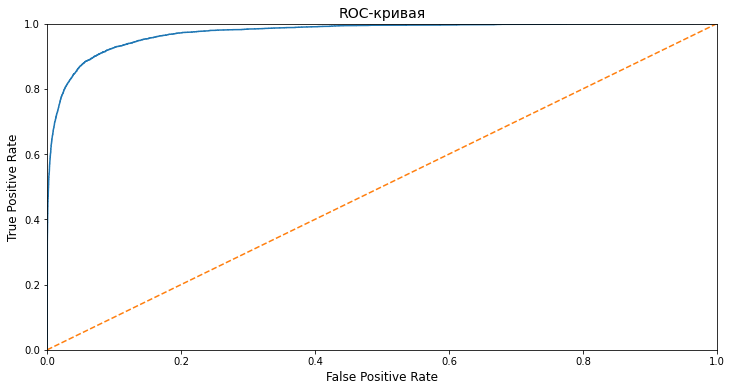

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title("ROC-кривая", fontsize=14)
plt.show()

### Вывод

В рамках этапа в результате перебора моделей была выбрана модель, показавшая на тестовой выборке наилучшее значение метрики $f1_{score}=0,78$. Этой моделью оказалась модель логистической регрессии. Модель показала наилучший результат при увеличении в тренировочной выборке количества строк с классом =1, что позволяет уменьшить влияние дисбаланса классов. 

Судя по значению метрики $Accuracy=0,86$ модель достаточно точно определяет токсичные комментарии. Однако, если взяглянуть на значение метрики $Recall=0,71$, можно понять, что модель отлавливает не все токсичные комментарии, только 71%. Для улучшения метрик можно более скурпулезно подойти к подбору гиперпараметров рассмотренных моделей, что, конечно же, увеличит время как самого исследования так и время обучения самих моделей. 

Кроме того, при желании по графику ROC-кривой можно подобрать такое значение порога классификации (соотношение парметров TPR и FPR), которое удовлетворит требования заказчика. К примеру, пожертвовать точностью определения токсичных комментариев (увеличится FPR), но затоповысить полноту определения истиннополжительных значений (TPR).

## Выводы

В рамках данного исследования был проведен анализ текстов комментариев и разработаны модели для предсказания по тексту комментария его токсчичности или нетокисчности.

На первом этапе проекта были сделаны предположения о влиянии соотношения количества слов с прописными буквами и общего количества символов в текстах, а также количества восклицательных знаков в текстах к общему количеству символов в текстах. Предположения были подтверждены на основе графиков распределения характеристик. Характеристики были добавлены в общую таблицу признаков. Также на первом этапе была проведена обработка и лемматизация текстов, создана таблица с оцнкой важности слов TF-IDF.

На втором этапе были построены несколько моделей, где в качестве признаков использовалась матрица с оценками важности слов TF-IDF c двумя допонительными признаками, выявленными на первом этапе. Для уменьшения влияния дисбаланса классов было рассмотрено несколько ваиантов решения: увеличение веса класса "1", увеличение в тренировочной выборке количества строк с классом "1", уменьшение количества строк с классом "0". Налучший результат $f1_{score}=0,78$ дала модель логистической регрессии с увеличенной за счет строк с классом "1" тренировочной выборкой. Данная модель обеспечила требование заказчика на значение метрики  $f1_{score}>0,75$.

Далее были разработаны модели предсказания с использованием нейронной сети DestillBert. Предварительно тексты комментариев были преобразованы нейронной сетью в эмбеддинги, которые в дальнейшем стали матрицей признаков для разрабатываемых моделей. Были рассмотрены модели логистической регрессии и LGBMClassifier. К сожалению, данные модели показали результат хуже чем модели на базе матрицы TF-IDF. Наилучший результат показала модель логистической регресии с $f1_{score}=0,72$, что не удовлетворяет поставленной задаче. Для улучшения результата моделей с использованием нейронных сетей необходимо лучше подбирать гиперпараметры моделей и сами модели классификации. Кроме того, можно рассматривать другие модели перевода слов в векторное сосотояние, различные варианты словарей, на которых обучались модели, варианты лемматизации текстов.